2-link arm model in jax

In [1]:
import jax
from jax import numpy as np
from jax.lax import scan
from jax import vmap, jit

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
sns.set_palette("colorblind")

In [2]:
# Parameters
N = 100
L1 = 30 / N  # length of upper arm
L2 = 33 / N# length of lower arm link
M1 = 1.4 # mass of upper arm link
M2 = 1.0 # mass of lower arm link
D2 = 16 /N# center of mass lower link, away from elbow
I1 = 0.025  # moment of inerta upper link
I2 = 0.045 # moment of intertia lower link
theta0 = np.array([10, 143.54]) * np.pi/180
d = 20 / N# reach distance

a1 = I1 + I2 + M2 * L1**2 
a2 = M2 * L1 * D2
a3 = I2

scale = 100


/home/mkp127/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [6]:

def get_M(theta):
    c = np.cos(theta[1])
    return scale * np.array([[a1 + 2*a2*c, a3 + a2*c], 
                     [a3 + a2*c, a3]])

def get_Chi(theta, thetadot):
    Chi = np.array([-thetadot[1]*(2*thetadot[0]+thetadot[1]), thetadot[0]**2])
    Chi *= a2 * np.sin(theta[1]) 
    return Chi * scale

B = np.array([[0.05, 0.025], [0.025, 0.05]]) * scale

def continuous_dynamics(x, m):
    # returns xdot = f(x,m)
    # x = [theta1, theta2, thetadot1, thetadot2]
    theta, thetadot = x[:2], x[2:]
    Minv = np.linalg.inv(get_M(theta))
    Chi = get_Chi(theta, thetadot)
    return np.concatenate((thetadot, Minv@(m - Chi -B@thetadot)))
    
def discrete_dynamics(x, m):
    dt = .1
    xnew = x + dt*continuous_dynamics(x, m)
    return xnew, xnew

def get_position(x):
    theta = x[:2]
    y1 = L1 * np.array([np.cos(theta[0]), np.sin(theta[0])])
    y2 = L2 * np.array([np.cos(theta.sum()), np.sin(theta.sum())])
    return y1 + y2

get_position_trj = vmap(get_position, in_axes=0)

def rollout(x0, m_trj):
    # x0: (4, ) 
    # m_trj: (time steps, 4)
    time_steps = m_trj.shape[0]
    _, x_trj = scan(discrete_dynamics, x0, m_trj)
    y_trj = get_position_trj(x_trj)
    return x_trj, y_trj

rollout_batch = jit(vmap(rollout, in_axes=(None, 0)))

In [4]:
with open('./data/arm_dt10.pickle', 'rb') as handle:
    d = pickle.load(handle)
print(d.keys())
m_trj = scale * d['torques']

dict_keys(['torques', 'positions', 'states'])


In [9]:
x0 = np.concatenate((theta0, np.zeros((2, ))))
x_trj, y_trj = rollout_batch(x0, m_trj)

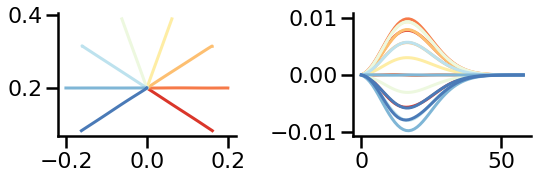

In [17]:
f, ax = plt.subplots(1,2, figsize=(8,3))
sns.set_palette("RdYlBu", 8)
for i in range(8):
    ax[0].plot(y_trj[i,:,0], y_trj[i,:,1])
    ax[1].plot(np.diff(y_trj[i], axis=0), c=sns.color_palette()[i])
sns.despine()
f.tight_layout()